# Cifar10

In this exercise we will try to create a CNN that will classify not 2 but 10 different image labels. We get the images from the dataset named [Cifar10](http://www.cs.utoronto.ca/~kriz/cifar.html) 

* Import :
  * Tensorflow
  * Numpy 
  * Matplotlib.pyplot 

In [2]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
tf.__version__

'2.4.1'

* Using `tf.keras.utils.get_file` load the image files into your storage with this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip`

In [3]:
# First we download the .zip file containing all the images
tf.keras.utils.get_file("/content/cifar10.zip",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
                        extract=True,
                        cache_subdir="/content")

119734272/119728390 [==============================] - 1s 0us/step


'/content/cifar10.zip'

* Import the dataframe containing the labels from this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv`

In [4]:
# Then the DataFrame containing the name of the image files and the value of the 
# target variable
import pandas as pd
data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


* Turn the `id` column into string type and add `.png` at the end of each string for the filenames to be complete

In [5]:
data["id"] = data["id"].astype("str") + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


* Load and display an image of your dataset 

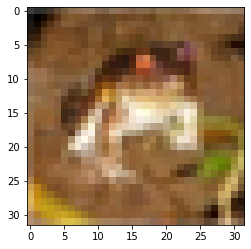

In [6]:
# Visualize a random picture
img = tf.io.read_file("/content/train/1.png")
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)

* View a random image of each of your labels in your dataset * View a random image of each of your labels in your dataset 

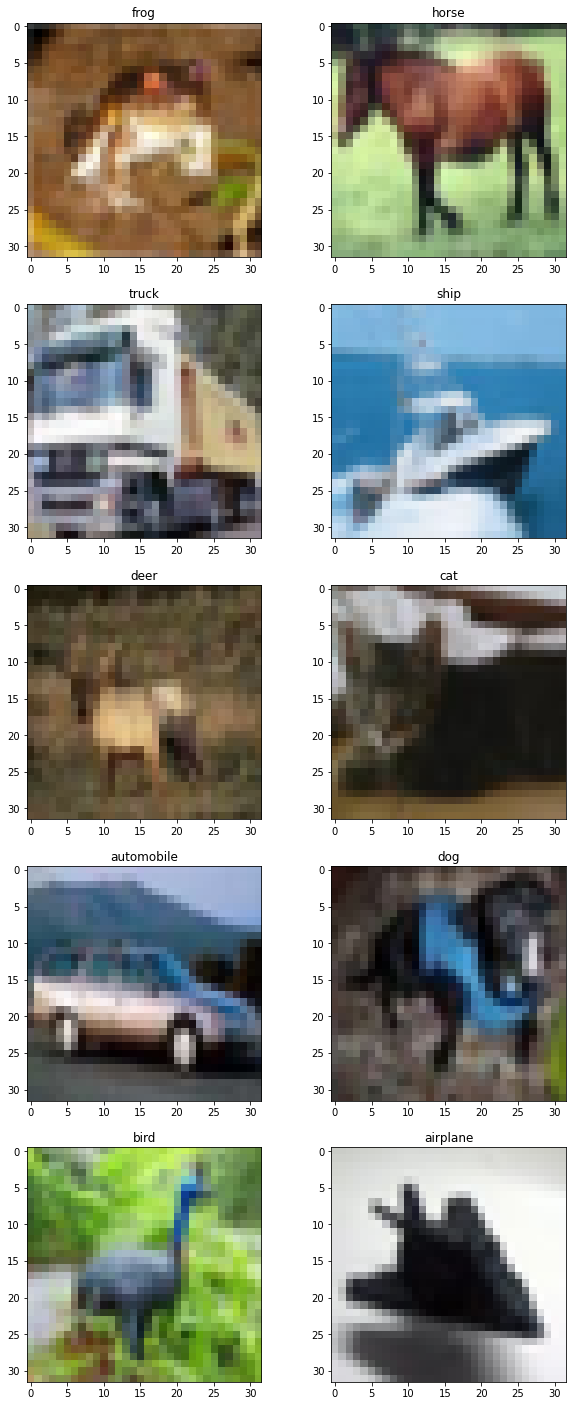

In [7]:
data_per_label = data.loc[data["label"].duplicated()==False]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,25))
for i in range(5):
  for j in range(2):
    filename = "/content/train/" + data_per_label.iloc[i+j*5,0]
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    axes[i,j].imshow(img)
    axes[i,j].title.set_text(data_per_label.iloc[i+j*5,1])

* Define an instance of an `ImageDataGenerator` Class with the data augmentation parameters of your choice, and `validation_split=0.3`

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_generator = ImageDataGenerator(
    rotation_range=0, # Angle range for random image rotation
    width_shift_range=0.0, # Random shift of the image along width axis
    height_shift_range=0.0, # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.0, # Random distortion of the image
    zoom_range=0.0, # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True, # Randomly flips image horizontally
    vertical_flip=True, # Randomly flips image virtically
    rescale=1/255., # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3 # Portion of the data that can be saved for validation
)

* Set up one generator for the train data and one for the test data using the method that lets you generate data with a dataframe. Since we have many images in this dataset, we will create large batches of 64 images.
Use a target size of `(32,32)` and class_mode `"sparse"`

In [9]:
train_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,
    subset = "training"
)

val_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,
    subset = "validation"
)

Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


* Display a batch of data of train data

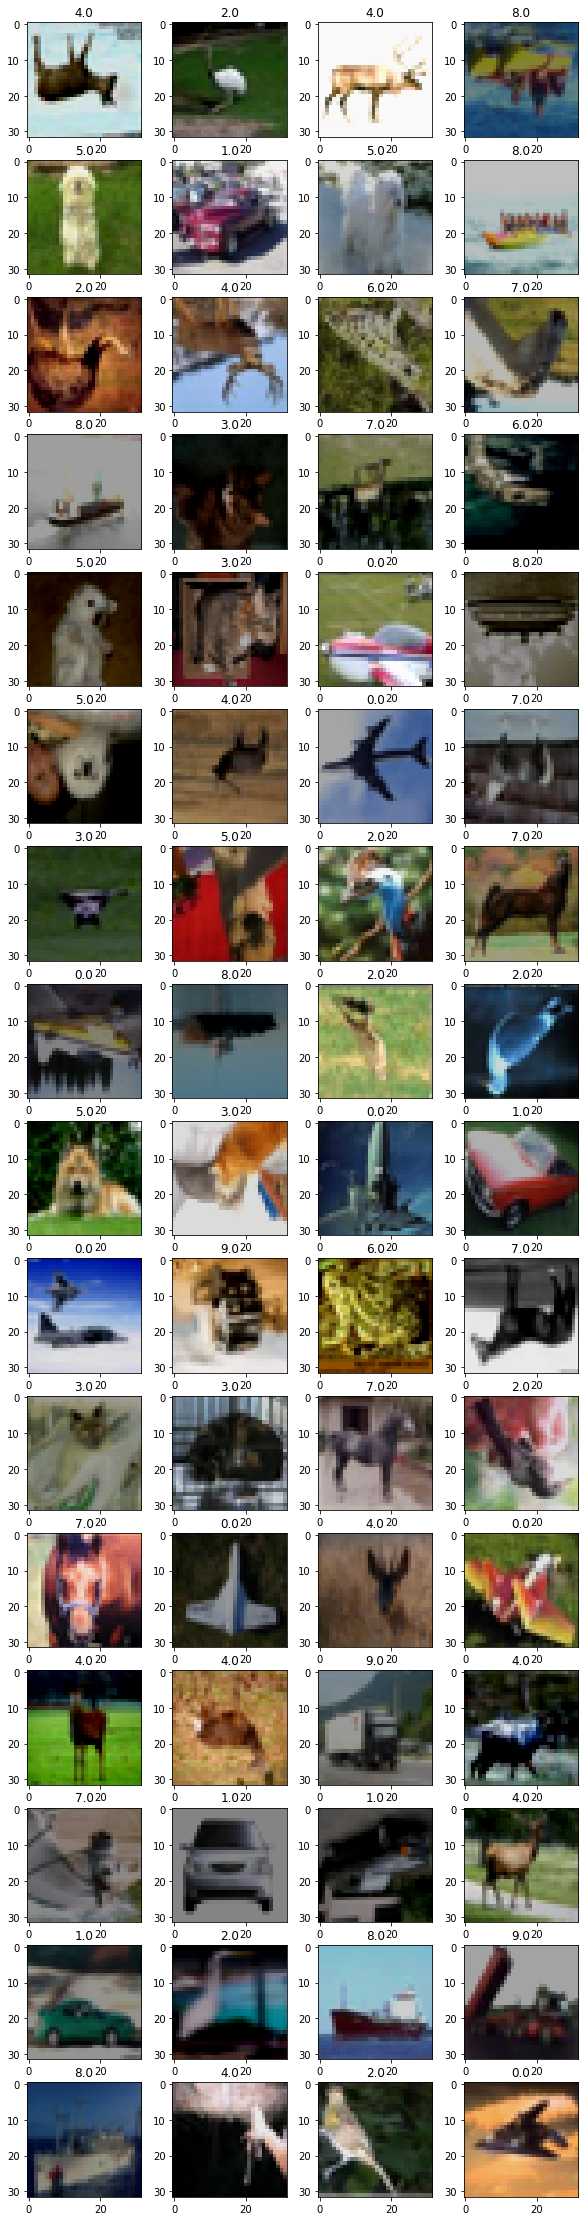

In [10]:
imgs, targets = next(iter(train_generator))
fig, ax = plt.subplots(16,4, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-16*(i//16),i//16].imshow(img)
  ax[i-16*(i//16),i//16].title.set_text(str(target))
fig.show()

* How many times can you divide the images by two along each axis until you reduce the images to single pixel?

In [11]:
a = 32
while a>1 :
  print(a, "->" , a/2)
  a=a/2

32 -> 16.0
16.0 -> 8.0
8.0 -> 4.0
4.0 -> 2.0
2.0 -> 1.0


* Build a neural network with a single convolution layer with 32 neurons, kernel size `(3,3)`, padding `"same"`, and activation `"relu"`, a max pooling layer, a flatten layer, then finish up the network with a dense layer that can predict the target variable.

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


* Compile the model using the right loss function and metric(s) and the Adam optimizer with default learning rate

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

* Train the model over 50 epochs

In [ ]:
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 42s 76ms/step - loss: 1.9570 - sparse_categorical_accuracy: 0.3054 - val_loss: 1.7591 - val_sparse_categorical_accuracy: 0.3829
Epoch 2/50
547/547 [==============================] - 41s 75ms/step - loss: 1.7053 - sparse_categorical_accuracy: 0.4019 - val_loss: 1.7225 - val_sparse_categorical_accuracy: 0.3887
Epoch 3/50
547/547 [==============================] - 41s 75ms/step - loss: 1.6274 - sparse_categorical_accuracy: 0.4373 - val_loss: 1.5888 - val_sparse_categorical_accuracy: 0.4428
Epoch 4/50
547/547 [==============================] - 41s 74ms/step - loss: 1.5556 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.5327 - val_sparse_categorical_accuracy: 0.4682
Epoch 5/50
547/547 [==============================] - 41s 74ms/step - loss: 1.5113 - sparse_categorical_accuracy: 0.4823 - val_loss: 1.5425 - val_sparse_categorical_accuracy: 0.4591
Epoch 6/50
547/547 [==============================] - 40s 74ms/step - loss: 1.4718 - spars

* Save the model under `cifar10model1conv.h5`

In [ ]:
model.save("/content/cifar10model1conv.h5")

* Use the following code to save the model's history (it does not get saved with the model)

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model1convhistory.json", 'w'))

* You may get the model's history with this code (for instructors not to have to train the whole model during the session)

In [ ]:
tf.keras.utils.get_file("/content/cifar10model1convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1convhistory.json")

'/content/cifar10model1convhistory.json'

* Load the history .json file using the following command (for instructors)

In [ ]:
history_dict = json.load(open("/content/cifar10model1convhistory.json", 'r'))

* Load the previously saved model using the two following commands (for instructors)

In [ ]:
tf.keras.utils.get_file("/content/cifar10model1conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1conv.h5")

'/content/cifar10model1conv.h5'

In [ ]:
model = tf.keras.models.load_model("/content/cifar10model1conv.h5")

* Display the evolution of the loss and the validation loss using plotly

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

The model looks it starts to overfit after 30 epochs and it trains smoothly on the training data.

* Build a new model and add a new convolution layer with double the number of neurons on it followed by a max pooling, and reproduce all the same steps as before.

In [14]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40970     
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
__________________________________________________

In [15]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [16]:
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 74s 81ms/step - loss: 1.9249 - sparse_categorical_accuracy: 0.3155 - val_loss: 1.5970 - val_sparse_categorical_accuracy: 0.4236
Epoch 2/50
547/547 [==============================] - 43s 79ms/step - loss: 1.5213 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.4126 - val_sparse_categorical_accuracy: 0.5047
Epoch 3/50
547/547 [==============================] - 43s 78ms/step - loss: 1.3945 - sparse_categorical_accuracy: 0.5229 - val_loss: 1.3361 - val_sparse_categorical_accuracy: 0.5391
Epoch 4/50
547/547 [==============================] - 43s 78ms/step - loss: 1.3230 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.5495
Epoch 5/50
547/547 [==============================] - 43s 79ms/step - loss: 1.3026 - sparse_categorical_accuracy: 0.5513 - val_loss: 1.2765 - val_sparse_categorical_accuracy: 0.5571
Epoch 6/50
547/547 [==============================] - 43s 78ms/step - loss: 1.2690 - spars

In [18]:
model.save("/content/cifar10model2conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model2convhistory.json", 'w'))

In [19]:
tf.keras.utils.get_file("/content/cifar10model2convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2convhistory.json")
tf.keras.utils.get_file("/content/cifar10model2conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2conv.h5")
history_dict = json.load(open("/content/cifar10model2convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model2conv.h5")

In [20]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Here it seems pretty clear that just by adding a second convolutional layer in our network we are able to reach lower values of the loss function in fewer epochs, and despite the fact that our second model has much fewer parameters!

* Repeat the same steps adding a third convolutional layer with `128` neurons on it, followed my a max pooling layer.

In [21]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

In [22]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 44s 80ms/step - loss: 1.8558 - sparse_categorical_accuracy: 0.3331 - val_loss: 1.4600 - val_sparse_categorical_accuracy: 0.4815
Epoch 2/50
547/547 [==============================] - 44s 80ms/step - loss: 1.4115 - sparse_categorical_accuracy: 0.5081 - val_loss: 1.2783 - val_sparse_categorical_accuracy: 0.5597
Epoch 3/50
547/547 [==============================] - 44s 81ms/step - loss: 1.2610 - sparse_categorical_accuracy: 0.5634 - val_loss: 1.2244 - val_sparse_categorical_accuracy: 0.5731
Epoch 4/50
547/547 [==============================] - 44s 80ms/step - loss: 1.1979 - sparse_categorical_accuracy: 0.5864 - val_loss: 1.1963 - val_sparse_categorical_accuracy: 0.5829
Epoch 5/50
547/547 [==============================] - 44s 81ms/step - loss: 1.1179 - sparse_categorical_accuracy: 0.6140 - val_loss: 1.1605 - val_sparse_categorical_accuracy: 0.5995
Epoch 6/50
547/547 [==============================] - 44s 80ms/step - loss: 1.0806 - spars

In [23]:
model.save("/content/cifar10model3conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model3convhistory.json", 'w'))

In [24]:
tf.keras.utils.get_file("/content/cifar10model3convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3convhistory.json")
tf.keras.utils.get_file("/content/cifar10model3conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3conv.h5")
history_dict = json.load(open("/content/cifar10model3convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model3conv.h5")

In [25]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

* Let's build the same model and double the number of convolutional neurons on each layer.

In [26]:
model = Sequential(
    [
     Conv2D(64, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(256, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)             

In [27]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 45s 82ms/step - loss: 1.8281 - sparse_categorical_accuracy: 0.3429 - val_loss: 1.3984 - val_sparse_categorical_accuracy: 0.5139
Epoch 2/50
547/547 [==============================] - 45s 81ms/step - loss: 1.3500 - sparse_categorical_accuracy: 0.5321 - val_loss: 1.2253 - val_sparse_categorical_accuracy: 0.5808
Epoch 3/50
547/547 [==============================] - 45s 82ms/step - loss: 1.2079 - sparse_categorical_accuracy: 0.5842 - val_loss: 1.2232 - val_sparse_categorical_accuracy: 0.5772
Epoch 4/50
547/547 [==============================] - 45s 81ms/step - loss: 1.1226 - sparse_categorical_accuracy: 0.6161 - val_loss: 1.1024 - val_sparse_categorical_accuracy: 0.6181
Epoch 5/50
547/547 [==============================] - 45s 82ms/step - loss: 1.0556 - sparse_categorical_accuracy: 0.6366 - val_loss: 1.1479 - val_sparse_categorical_accuracy: 0.6067
Epoch 6/50
547/547 [==============================] - 44s 81ms/step - loss: 0.9973 - spars

In [29]:
model.save("/content/cifar10model4conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model4convhistory.json", 'w'))

In [33]:
tf.keras.utils.get_file("/content/cifar10model4convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4convhistory.json")
tf.keras.utils.get_file("/content/cifar10model4conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4conv.h5")
history_dict = json.load(open("/content/cifar10model4convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model4conv.h5")

In [34]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Increasing the number of neurons on each layer is causing the model to quickly overfit! But it trains really on the training data.

* In the time remaining, build a model by duplicating the convolutional layers before every maxpooling adn go back to the original number of neurons. Look at the model summary for reference. This last model will have 6 different convolutional layers, let's see the effect of this on the predictions

In [30]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     Conv2D(32, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)        

In [31]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 47s 85ms/step - loss: 1.8324 - sparse_categorical_accuracy: 0.3377 - val_loss: 1.3718 - val_sparse_categorical_accuracy: 0.5243
Epoch 2/50
547/547 [==============================] - 47s 85ms/step - loss: 1.3533 - sparse_categorical_accuracy: 0.5289 - val_loss: 1.2611 - val_sparse_categorical_accuracy: 0.5575
Epoch 3/50
547/547 [==============================] - 46s 84ms/step - loss: 1.2023 - sparse_categorical_accuracy: 0.5838 - val_loss: 1.1552 - val_sparse_categorical_accuracy: 0.6015
Epoch 4/50
547/547 [==============================] - 46s 85ms/step - loss: 1.1298 - sparse_categorical_accuracy: 0.6167 - val_loss: 1.1432 - val_sparse_categorical_accuracy: 0.5979
Epoch 5/50
547/547 [==============================] - 46s 84ms/step - loss: 1.0584 - sparse_categorical_accuracy: 0.6370 - val_loss: 1.1101 - val_sparse_categorical_accuracy: 0.6247
Epoch 6/50
547/547 [==============================] - 46s 84ms/step - loss: 1.0291 - spars

In [32]:
model.save("/content/cifar10model5conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model5convhistory.json", 'w'))

In [35]:
tf.keras.utils.get_file("/content/cifar10model5convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5convhistory.json")
tf.keras.utils.get_file("/content/cifar10model5conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5conv.h5")
history_dict = json.load(open("/content/cifar10model5convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model5conv.h5")

In [36]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Adding more convolutional layers helps a little but does not really improve the results for this dataset.